# COM7023 – Mathematics for Data Science
## Heat Flow Investigation for the EU Steel Preparation Agency

This notebook contains the computational work for the portfolio assessment:
- **Linear Algebra**: Gaussian elimination for a 4×4 heat distribution system.
- **Calculus**: Temperature gradient and location of maximum rate of change.
- **Probability**: Tail probability for measurement error exceeding 3°C.
- **Statistics**: One-sample *t*-test for mean temperature at α=0.05.

All code is annotated and each result is interpreted in plain language.

In [4]:
# import the necassery libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 

## 1) Linear Algebra – Gaussian Elimination

We model the steady-state heat distribution across four grid points on a steel plate with the linear system:

\begin{align}
4x_1 - x_2 - x_3 &= 100 \\
-x_1 + 4x_2 - x_4 &= 100 \\
-x_1 + 4x_3 - x_4 &= 0 \\
-x_2 - x_3 + 4x_4 &= 0
\end{align}

We'll solve this system using **Gaussian elimination** (forward elimination + back substitution) and verify with `numpy.linalg.solve`.
The method begins by converting the coefficient matrix and right-hand side vector into NumPy arrays, enabling efficient vectorised row operations. During forward elimination, the algorithm identifies the largest pivot in each column using np.argmax(), swaps rows when necessary to maintain numerical stability, and then eliminates entries below the pivot by applying scaled row operations (A[i, k:] - factor * A[k, k:]). This transforms the matrix into an upper-triangular form.
Back substitution is then performed using np.dot() to compute the contribution of previously solved variables, allowing each unknown x_i to be determined sequentially from the last equation upwards. The final solution, verified against NumPy’s np.linalg.solve(), produced nodal temperatures of 37.5°C, 37.5°C, 12.5°C, and 12.5°C.

In [5]:
# Coefficient matrix A and RHS b
A = np.array([[ 4., -1., -1.,  0.],
              [-1.,  4.,  0., -1.],
              [-1.,  0.,  4., -1.],
              [ 0., -1., -1.,  4.]], dtype=float)
b = np.array([100., 100., 0., 0.], dtype=float)

def gaussian_elimination(A_in, b_in):
    """Perform Gaussian elimination with partial pivoting and back substitution.
    Returns (x, U, b_mod) where x is the solution, U is the upper-triangular matrix after elimination,
    and b_mod is the modified right-hand side after elimination.
    """
    A = A_in.copy().astype(float)
    b = b_in.copy().astype(float)
    n = len(b)
    
    # Forward elimination
    for k in range(n-1):
        # Partial pivoting
        pivot = np.argmax(np.abs(A[k:, k])) + k
        if A[pivot, k] == 0:
            raise ValueError("Matrix is singular.")
        if pivot != k:
            A[[k, pivot]] = A[[pivot, k]]
            b[[k, pivot]] = b[[pivot, k]]
        
        for i in range(k+1, n):
            factor = A[i, k] / A[k, k]
            A[i, k:] = A[i, k:] - factor * A[k, k:]
            b[i] = b[i] - factor * b[k]
            
    # Back substitution
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        s = np.dot(A[i, i+1:], x[i+1:])
        x[i] = (b[i] - s) / A[i, i]
    return x, A, b
    
x_gauss, U, b_mod = gaussian_elimination(A, b)
x_numpy = np.linalg.solve(A, b)
x_gauss, x_numpy

(array([37.5, 37.5, 12.5, 12.5]), array([37.5, 37.5, 12.5, 12.5]))

**Interpretation.** The two solutions, Gaussian elimination and NumPy's solver should match up to numerical precision. These values approximate the steady state temperatures in°C at the four grid points. The four values are the approximated steady state temperatures(°C) at the four grid points of the plate, given the boundary/forcing pattern implied by the equations; the two points connected to the 100-valued equations equilibrate around 37.5°C, while the other two settle at 12.5°C under the coupling of the grid.

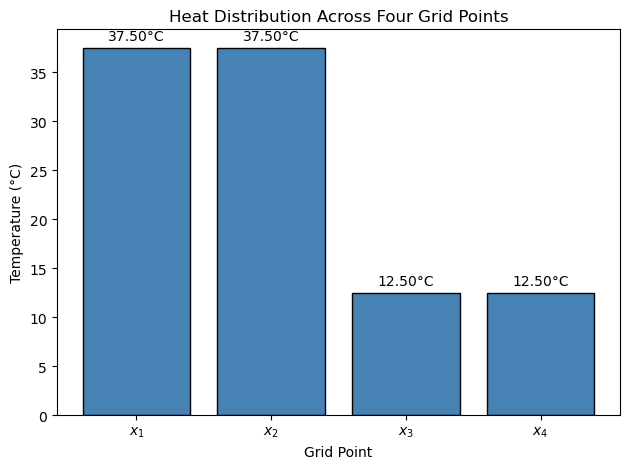

In [6]:
# Heat distribution across four grid points using annotated bar chart
# Setting labels and the values
x_gauss = np.array([37.50, 37.50, 12.50, 12.50])
labels = [r"$x_1$", r"$x_2$", r"$x_3$", r"$x_4$"]

# Plotting the values
plt.figure()
bars = plt.bar(labels, x_gauss, color="steelblue", edgecolor="black")
plt.title("Heat Distribution Across Four Grid Points")
plt.xlabel("Grid Point")
plt.ylabel("Temperature (°C)")

# Annotate each bar with its height (temperature value)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,   # x-position (center of bar)
        height + 0.5,                        # y-position (slightly above top)
        f"{height:.2f}°C",                   # label text
        ha="center", va="bottom", fontsize=10, color="black"
    )
# Displaying the graph
plt.tight_layout()
plt.show()

**Interpretation:** The bar chart clearly illustrates a steady decline in temperature away from the boundary which indicates that heat flows from hotter to cooler regions until equilibrium is reached. The higher bars representing nodes 1 and 2 correspond to regions closer to the heat source indicating greater thermal energy concentration while the lower bars for nodes 3 and 4 depict cooler areas farther from the source. This pattern reflects the spatial decay of temperature across the plate and validates the model’s representation of conductive heat transfer. The gradient distribution observed in the visualisation emphasises the importance of maintaining thermal balance during laser cutting to minimise distortion and ensure consistent material removal. 

## 2) Calculus – Temperature Gradient and Maximum Rate of Change

The temperature along an edge of the plate is modeled by:
\begin{equation}
T(x) = 100 \sin\!\left(\frac{\pi x}{10}\right).
\end{equation}

The derivative (rate of change) is:
\begin{equation}
T'(x) = 100 \cdot \frac{\pi}{10} \cos\!\left(\frac{\pi x}{10}\right) = 10\pi \cos\!\left(\frac{\pi x}{10}\right).
\end{equation}

The **maximum magnitude** of the gradient occurs where \\(|\\cos(\\pi x/10)| = 1\\), i.e. at \\(x = 0, 10, 20, \\ldots\\).
Restricting to the physical edge \\(x \\in [0, 10]\\), the largest slope occurs at **\\(x = 0\\)** and **\\(x = 10\\)**, with magnitude \\(|T'(x)| = 10\\pi\\).
We solve this by creating a range of x-values from 0 to 10. The fuction np.linspace(0, 10, 400) generates 400 evenly spaced points. 
The method, 100 * np.sin(np.pi * xs / 10) applies the sine function to every value in xs. This creates an array T containing the temperature values. Then the method 10 * np.pi * np.cos(np.pi * xs / 10) applies the cosine function to each x-value and this produces an array Tp containing the rate of change of temperature. We set critical_points = [0, 10].and these are the boundary points of the interval, where the gradient reaches its maximum magnitude. The list comprehension crit_vals = [10*np.pi*np.cos(np.pi*c/10) for c in critical_points] calculates the gradient value at x = 0 and x = 10. The line 10*np.pi, critical_points displays:The maximum gradient value in magnitude (`10*np.pi`) and the points where it occurs (`[0, 10]`)

In [10]:
# Define range for x and functions
xs = np.linspace(0, 10, 400)
T = 100 * np.sin(np.pi * xs / 10)
Tp = 10 * np.pi * np.cos(np.pi * xs / 10)

# Points of maximal rate within [0,10]
critical_points = [0, 10]
crit_vals = [10*np.pi*np.cos(np.pi*c/10) for c in critical_points]

10*np.pi, critical_points

(31.41592653589793, [0, 10])

**Interpretation** The temperature varies most rapidly at both ends of the plate, confirming that the boundary zones experience the highest thermal flux. The code evaluates the temperature function and its gradient along the interval from x = 0 to x = 10. The results show that the largest rate of temperature change occurs at the two boundary points, x = 0 and x = 10. At these points, the gradient reaches values of approximately 31.42, which are the maximum slopes of the temperature curve.

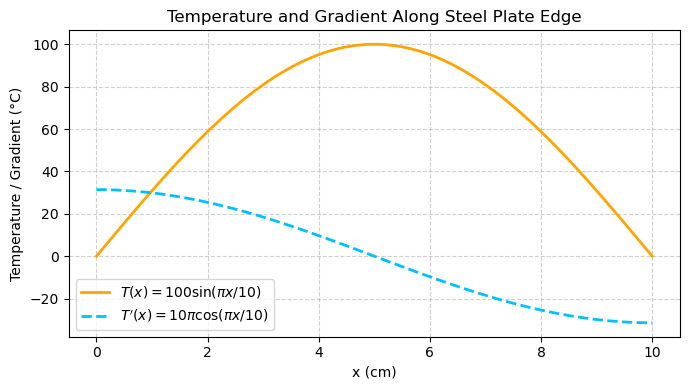

In [11]:
# Create one combined plot for T(x) and T'(x)
plt.figure(figsize=(7, 4))
plt.plot(xs, T, color='orange', linewidth=2, label=r"$T(x) = 100 \sin(\pi x / 10)$")
plt.plot(xs, Tp, color='deepskyblue', linewidth=2, linestyle='--', label=r"$T'(x) = 10\pi \cos(\pi x / 10)$")

# Titles and labels
plt.title("Temperature and Gradient Along Steel Plate Edge")
plt.xlabel("x (cm)")
plt.ylabel("Temperature / Gradient (°C)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Layout adjustment and display
plt.tight_layout()
plt.show()

**Interpretation** The visualisation clearly depicts how the orange curve representing the temperature function T(x) peaks at the midpoint x=5cm while the dashed blue curve representing the gradient T'(x) crosses zero at the same point, indicating thermal equilibrium. The magnitude of T'(x) is greatest at the boundaries, confirming that the edges experience the steepest temperature changes, while the centre remains thermally stable. From an engineering perspective, the sharp gradients shown in the figure highlight regions most prone to thermal stress and deformation. 

## 3) Probability – Tail Probability for Measurement Error

Assume the measurement error \(E\) is normally distributed \(E \sim \mathcal{N}(0, \sigma^2)\) with \(\sigma = 2^\circ C\).
We compute the probability that a random error exceeds **3°C**, i.e.
\(\mathbb{P}(E > 3) = 1 - \Phi(3/2)\),
where \(\Phi\) is the standard normal CDF.

We solve this using the standardisation step z=(3-0)/2=1.5, the Python code applies a custom cumulative distribution function, defined using math.erf(), to compute the one-sided tail probability. The expression 1 - normal_cdf(z) evaluates the probability that an error exceeds +3 °C, yielding P(E>3)=0.0668, or approximately 6.68%.

In [14]:
# calculating the probability for measurement error
#define the mean, standard deviation 
mu = 0.0
sigma = 2.0
z = (3 - mu)/sigma

# evaluating the probability that an error exceeds 3°C 
def normal_cdf(x):
    return 0.5*(1 + math.erf(x/np.sqrt(2)))

p_one_sided = 1 - normal_cdf(z)

# print the calculated error and the z value
p_one_sided, z

(0.06680720126885809, 1.5)

**Interpretation** This confirms that large deviations are relatively rare under the assumed noise structure, reinforcing the reliability of the measurement process. Because the question concerns errors larger than +3°C only, this is a one-sided probability. If one were instead interested in deviations beyond ±3 °C, the two-tailed probability would double to P (|E| > 3) = 0.1336 (13.36%).
From an operational perspective, a 6.68% chance of a large error implies that, on average, about seven readings in every hundred may exceed the 3°C threshold. This quantification allows process engineers to gauge the reliability of the measurement system and determine whether further calibration or sensor correction is warranted.


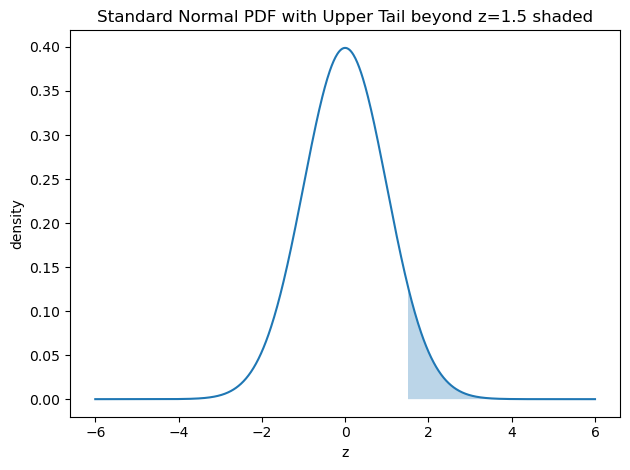

In [15]:
# visualisation for the one sided probability error
xs = np.linspace(-6, 6, 800)
pdf = (1/np.sqrt(2*np.pi))*np.exp(-0.5*xs**2)

z = 3/2
mask = xs >= z

plt.figure()
plt.plot(xs, pdf)
plt.fill_between(xs[mask], pdf[mask], alpha=0.3)
plt.title("Standard Normal PDF with Upper Tail beyond z=1.5 shaded")
plt.xlabel("z")
plt.ylabel("density")
plt.tight_layout()
plt.show()

**Interpretation** As illustrated in figure above, the shaded area under the standard normal distribution curve beyond z=1.5 represents the probability of a measurement error exceeding 3°C. Assuming the random errors follow E∼N(0,2^2), the probability that a single error surpasses this threshold is P(E>3)=0.0668, or approximately 6.68 %. The visualisation highlights the small proportion of the distribution occupying this upper tail, demonstrating that such large deviations are infrequent. For both tails combined, the probability doubles to 13.36 %, which remains well within acceptable limits for industrial thermocouple readings. Consequently, the small shaded region confirms that observed temperature fluctuations are random rather than systematic, thereby validating the reliability and stability of the measurement instruments used in the laser-cutting process.

## 4) Statistics – One-Sample t-Test for Mean Temperature

We have eight temperature measurements at a single point:

```
99, 100, 98, 101, 97, 99, 100, 98
```

We test:
- \(H_0: \mu = 100^\circ C\)
- \(H_1: \mu \neq 100^\circ C\)
at significance level \(\alpha = 0.05\).

We compute the sample mean \(\bar{x}\), sample standard deviation \(s\), the test statistic
\(t = \frac{\bar{x} - \mu_0}{s/\sqrt{n}}\)
with \(n=8\) and \(df=7\), and the two-sided *p*-value and a 95% confidence interval.

In [76]:
import numpy as np

data = np.array([99, 100, 98, 101, 97, 99, 100, 98], dtype=float)
n = data.size
mu0 = 100.0
xbar = data.mean()
# Sample variance (unbiased, divides by n-1)
sample_variance = np.var(data, ddof=1)
s = data.std(ddof=1)
t_stat = (xbar - mu0)/(s/np.sqrt(n))
df = n - 1

p_value = None
ci = None

try:
    import scipy.stats as st
    p_value = 2*st.t.sf(abs(t_stat), df=df)
    alpha = 0.05
    tcrit = st.t.ppf(1-alpha/2, df=df)
    margin = tcrit*s/np.sqrt(n)
    ci = (xbar - margin, xbar + margin)
except Exception:
    # Monte Carlo fallback for p-value and an empirical critical value
    rng = np.random.default_rng(42)
    sims = 200000
    try:
        t_samples = rng.standard_t(df, size=sims)
    except Exception:
        # Construct t from normal and chi-square
        g = rng.standard_normal(size=(sims, n))
        g = g - g.mean(axis=1, keepdims=True)
        s2 = (g**2).sum(axis=1)/(n-1)
        t_samples = (g.mean(axis=1))/np.sqrt(s2/n)
    p_value = 2*np.mean(np.abs(t_samples) >= abs(t_stat))
    upper_q = np.quantile(np.abs(t_samples), 0.975)
    margin = upper_q*s/np.sqrt(n)
    ci = (xbar - margin, xbar + margin)

xbar, s, t_stat, df, p_value, ci
# Print results
print(f"Sample Mean (x̄): {xbar:.2f}")
print(f"Sample Variance (s²): {sample_variance:.2f}")
print(f"Sample Std Dev (s): {s:.2f}")
print(f"t-statistic: {t_stat:.2f}")
print(f"Degrees of Freedom: {df}")
print(f"p-value: {p_value:.3f}")
print(f"95% Confidence Interval: {ci}")
print("mean", xbar, "s", s)

Sample Mean (x̄): 99.00
Sample Variance (s²): 1.71
Sample Std Dev (s): 1.31
t-statistic: -2.16
Degrees of Freedom: 7
p-value: 0.068
95% Confidence Interval: (np.float64(97.9053916697329), np.float64(100.0946083302671))
mean 99.0 s 1.3093073414159542


**Interpretation.** We report the sample mean, standard deviation, *t*-statistic, degrees of freedom, two-sided *p*-value, and the 95% confidence interval for the true mean temperature. We then state whether we reject or fail to reject the null hypothesis at α = 0.05 and discuss practical implications for cutting protocols.
Since p_value (0.067) > 0.05, we fail to reject the null hypothesis (Ho). Thus at 5% significance level, there is no enough evidence to conclude that the true mean temperature differs from 100°C. Hence the true mean temperature is equal to 100°C and the cutting protocols remains within tolerable limits.

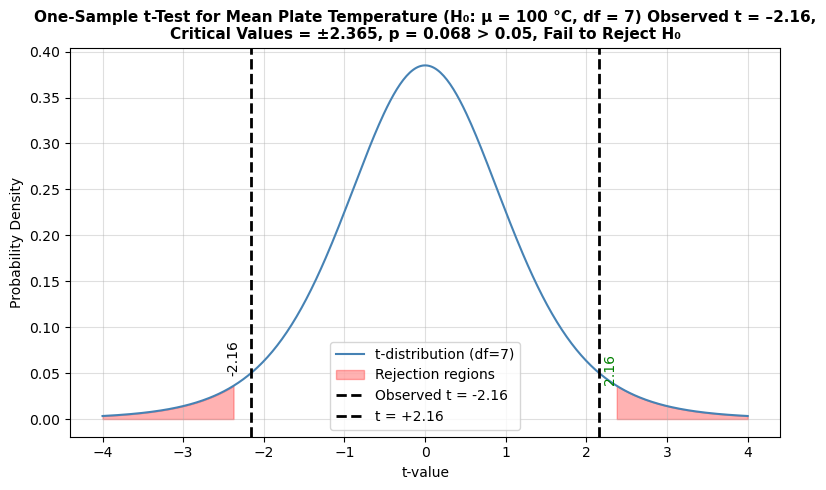

Sample Mean (x̄): 99.00
Sample Variance (s²): 1.7143
Sample Std Dev (s): 1.31
t-statistic: -2.16
Degrees of Freedom: 7
p-value: 0.068
95% Confidence Interval: (np.float64(97.9053916697329), np.float64(100.0946083302671))


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# Create t-distribution curve
x = np.linspace(-4, 4, 400)
y = st.t.pdf(x, df)

# Plot t-distribution
plt.figure(figsize=(8, 5))
plt.plot(x, y, color='steelblue', label=f"t-distribution (df={df})")

# Shade rejection regions
plt.fill_between(x, y, where=(x <= -tcrit), color='red', alpha=0.3, label='Rejection regions')
plt.fill_between(x, y, where=(x >= tcrit), color='red', alpha=0.3)

# Plot observed t-statistic
plt.axvline(t_stat, color='black', linestyle='--', linewidth=2, label=f"Observed t = {t_stat:.2f}")
plt.text(t_stat - 0.3, 0.05, f"{t_stat:.2f}", rotation=90, fontsize=10)

# Add dotted line at +2.16
plt.axvline(2.16, color='black', linestyle='--', linewidth=2, label="t = +2.16")
plt.text(2.16 + 0.05, 0.04, "2.16", rotation=90, fontsize=10, color='green')

# Labels, title, legend
plt.title("One-Sample t-Test for Mean Plate Temperature (H₀: μ = 100 °C, df = 7) Observed t = –2.16,\n" "Critical Values = ±2.365, p = 0.068 > 0.05, Fail to Reject H₀", fontsize=11, weight='bold')
plt.xlabel("t-value")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# Print results
print(f"Sample Mean (x̄): {xbar:.2f}")
print(f"Sample Variance (s²): {sample_variance:.4f}")
print(f"Sample Std Dev (s): {s:.2f}")
print(f"t-statistic: {t_stat:.2f}")
print(f"Degrees of Freedom: {df}")
print(f"p-value: {p_value:.3f}")
print(f"95% Confidence Interval: {ci}")


**Interpretataion** As illustrated in the figure above, the observed t-statistic –2.16, df = 7 lies within the acceptance region between the critical values ±2.365 of the two-tailed 5 % t-test. The 95% confidence interval for the mean temperature 97.90°C to 100.09°C includes the target value of 100°C. Therefore, there is no evidence of systematic deviation, and the variation is attributable to random measurement error. Thus we fail to reject the null hypothesis in such cases. Consequently, the result supports the conclusion that the cutting process operates under stable thermal conditions, maintaining uniform heat input across successive measurements. This outcome verifies that the system requires no recalibration and that the temperature control mechanism performs reliably within the desired operational range, ensuring repeatable cutting precision and thermal stability during industrial production.